In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import torch
from qubic.lib.AnalyticalSolution.graphs.healpix_graph import (
    # get_G_masked_by_cov,
    # get_G_masked_by_cov_multifeature,
    get_high_coverage_indexes,
    # get_nside_from_graph,
    healpix_graph,
    healpix_graph_multifeature,
    # healpix_weightmatrix,
    # healpix_weightmatrix_multifeature,
    plot_sky_3d,
    plot_sky_3d_multifeature,
)
from qubic.lib.AnalyticalSolution.operators.forward_ops import ForwardOps
from qubic.lib.Instrument.Qacquisition import QubicInstrumentType
from qubic.lib.Instrument.Qinstrument import QubicMultibandInstrument, compute_freq
from qubic.lib.MapMaking.FrequencyMapMaking.Qspectra_component import CMBModel
from qubic.lib.Qdictionary import qubicDict
from qubic.lib.Qsamplings import equ2gal, get_pointing
from qubic.lib.Qscene import QubicScene

In [2]:
%matplotlib inline

# QUBIC Parameters

In [3]:
dictfilename = "qubic/qubic/dicts/pipeline_demo.dict"
d = qubicDict()
d.read_from_file(dictfilename)

center = equ2gal(d["RA_center"], d["DEC_center"])

In [4]:
d["nf_recon"] = 4
d["nf_sub"] = 4
d["MultiBand"] = True
d["nside"] = 128

d["synthbeam_kmax"] = 1
nf_sub = d["nf_sub"]
d["synthbeam_fraction"] = 1

d["use_synthbeam_fits_file"] = False
d["noiseless"] = True
d["photon_noise"] = False
d["npointings"] = 100
d["instrument_type"] = "UWB"
nf_recon = d["nf_recon"]

# Build Sky

In [5]:
seed = 3
sky_config = {"cmb": seed}
cl_cmb = CMBModel(None).give_cl_cmb(r=0, Alens=1)
sky_map = np.array(d["nf_sub"] * [hp.synfast(cl_cmb, d["nside"], new=True, verbose=False).T])
print(sky_map.shape)

(4, 196608, 3)


# QUBIC Instances

In [6]:
p = get_pointing(d)
s = QubicScene(d)
q = QubicMultibandInstrument(d)
multiacquisition = QubicInstrumentType(d, nsub=4, nrec=4)

Info apcnb2325: Allocating (99200,9) elements = 13.623046875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (99200,9) elements = 13.623046875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (99200,9) elements = 13.623046875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (99200,9) elements = 13.623046875 MiB in FSRRotation3dMatrix.__init__.


In [7]:
_, nus_edge, nus, _, _, _ = compute_freq(d["filter_nu"] / 1e9, d["nf_sub"], d["filter_relative_bandwidth"])
nus

array([135.50540829, 144.29216391, 153.6486907 , 163.61193508])

# Build TOD

In [8]:
# Convolve sky

convolved_sky_map = np.zeros(sky_map.shape)
for i in range(sky_map.shape[0]):
    convolution = multiacquisition.subacqs[i].get_convolution_peak_operator()
    convolved_map = convolution(sky_map[i])
    convolved_sky_map[i] = convolved_map

In [9]:
# Build TOD

TOD_total = np.zeros((nf_recon, 992, d["npointings"]))
for i in range(len(multiacquisition.subacqs)):
    TOD_nsub = multiacquisition.subacqs[i].get_operator()(convolved_sky_map[i])
    TOD_total[i] = TOD_nsub

Info apcnb2325: Allocating (99200,9) elements = 13.623046875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (99200,9) elements = 13.623046875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (99200,9) elements = 13.623046875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (99200,9) elements = 13.623046875 MiB in FSRRotation3dMatrix.__init__.


# Plot Sky

In [10]:
seen_indexes = get_high_coverage_indexes(multiacquisition._get_coverage())
seen_indexes = hp.ring2nest(d["nside"], seen_indexes)

In [11]:
G = healpix_graph(d["nside"], indexes=seen_indexes)

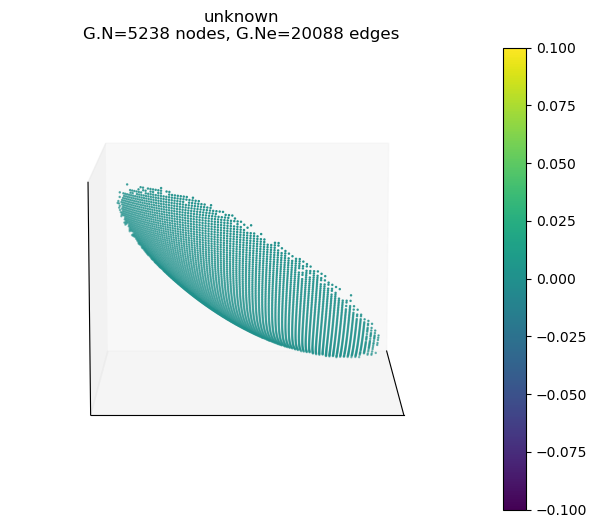

In [12]:
plot_sky_3d(G)

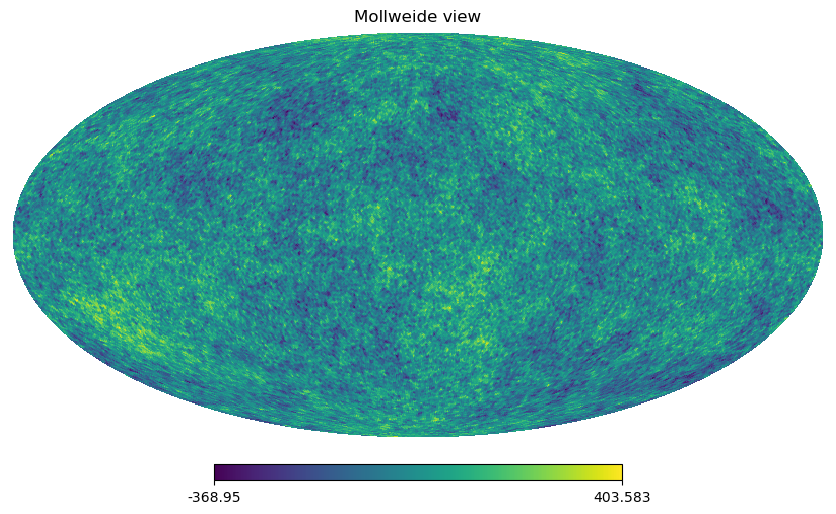

In [13]:
hp.mollview(convolved_sky_map[0, :, 0])

In [14]:
input_map_reord = hp.reorder(convolved_sky_map[0, :, 0], r2n=True)

G_sky = healpix_graph(nside=d["nside"], nest=True)

G_sky.signal = input_map_reord

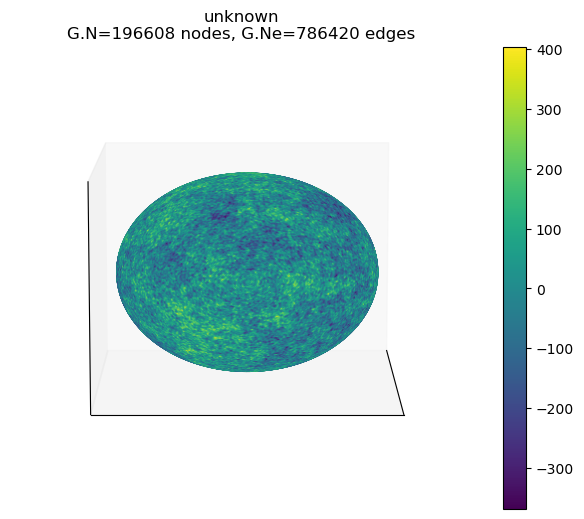

In [15]:
plot_sky_3d(G_sky)

In [16]:
G_sky_partial = G_sky.subgraph(seen_indexes)
G_sky_partial.signal = G_sky.signal[seen_indexes]

In [17]:
G_sky_partial.coords = G_sky.coords[seen_indexes]

In [18]:
G_sky_partial.coords

array([[ 0.5616815 , -0.54806221, -0.61979167],
       [ 0.45339775, -0.63545691, -0.625     ],
       [ 0.49891636, -0.6003811 , -0.625     ],
       ...,
       [ 0.22740581, -0.13702534, -0.96411133],
       [ 0.23237033, -0.12842654, -0.96411133],
       [ 0.2413179 , -0.11070238, -0.96411133]])

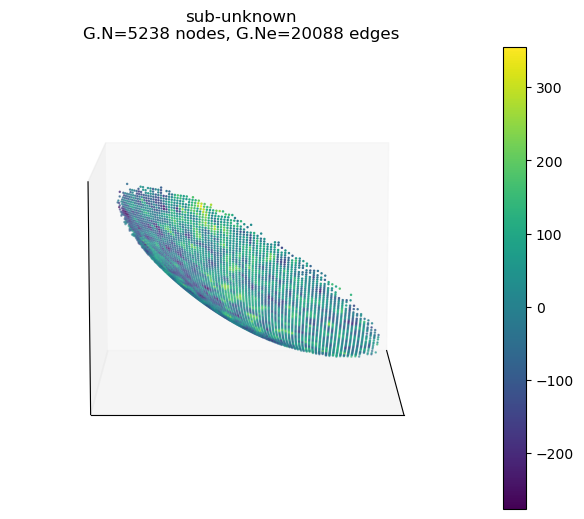

In [19]:
plot_sky_3d(G_sky_partial)

In [20]:
G_sky_multifeature = healpix_graph_multifeature(nside=d["nside"], nest=True)

In [21]:
input_map_reord_multifeature = np.zeros((convolved_sky_map.shape))

In [22]:
input_map_reord_multifeature[0, :, 0] = hp.reorder(convolved_sky_map[0, :, 0], r2n=True)
input_map_reord_multifeature[0, :, 1] = hp.reorder(convolved_sky_map[0, :, 1], r2n=True)
input_map_reord_multifeature[0, :, 2] = hp.reorder(convolved_sky_map[0, :, 2], r2n=True)

In [23]:
G_sky_multifeature.signal = input_map_reord_multifeature[0]

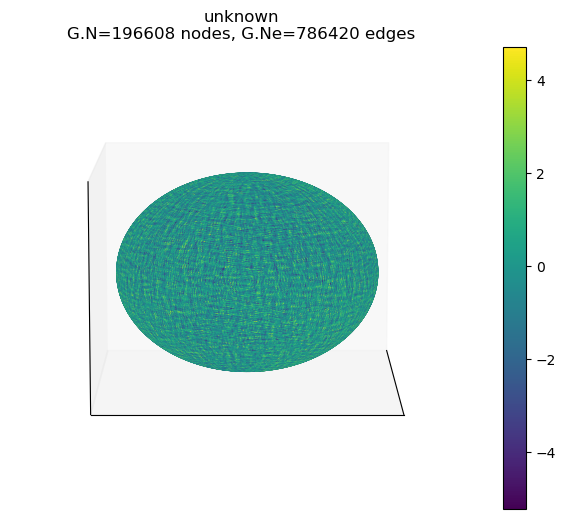

In [24]:
plot_sky_3d_multifeature(G_sky_multifeature, feature_index=1)

# Test

## Forward

In [33]:
forward_ops = ForwardOps(q[0], multiacquisition, s)

In [26]:
unit = forward_ops.op_unit_conversion()
aperture = forward_ops.op_aperture_integration()
filter = forward_ops.op_filter()
projection = forward_ops.op_projection()
hwp = forward_ops.op_hwp()
pol = forward_ops.op_polarizer()
det_inte = forward_ops.op_detector_integration()
transmission = forward_ops.op_transmission()
det_resp = forward_ops.op_bolometer_response()

Info apcnb2325: Allocating (99200,9) elements = 13.623046875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (99200,9) elements = 13.623046875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (99200,9) elements = 13.623046875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (99200,9) elements = 13.623046875 MiB in FSRRotation3dMatrix.__init__.


In [27]:
tod_test = det_resp(transmission(det_inte(pol(hwp(projection[0](filter(aperture(unit(sky_map[0])))))))))

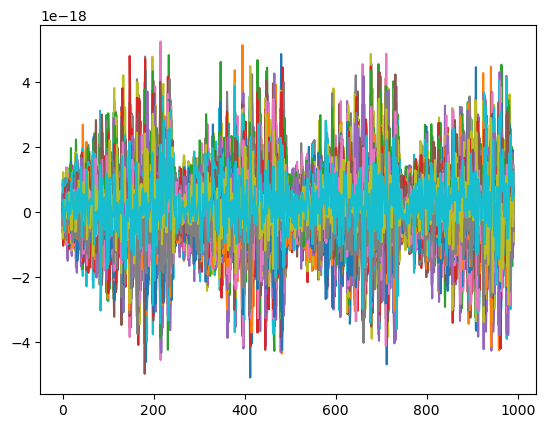

In [28]:
plt.plot(tod_test)

## Inverse

In [29]:
tod_test = torch.as_tensor(tod_test)

### Transmission

In [30]:
from qubic.lib.AnalyticalSolution.operators.inverse_ops import InverseTransmissionDeterministic, InverseTransmissionTrainable

#### Determinisitic

torch.Size([992, 100])


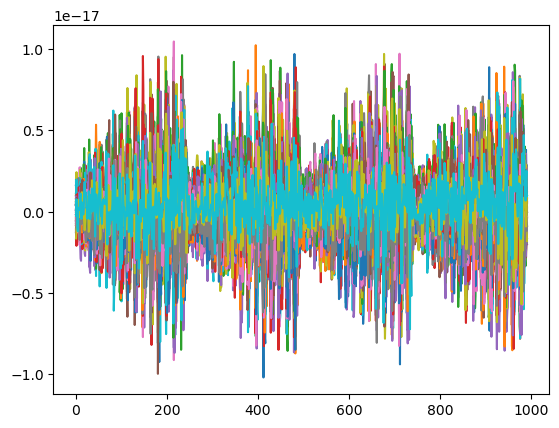

In [31]:
inv_trans_deterministric = InverseTransmissionDeterministic(q[0])

tod_trans = inv_trans_deterministric(tod_test)[0]
print(tod_trans.shape)

plt.plot(tod_trans)
plt.show()

#### Trainable

In [32]:
q = QubicMultibandInstrument(d)[0]

T_optics = np.prod(q.optics.components["transmission"]).copy()
eta_true = np.mean(q.detector.efficiency).copy()
D, Nt = 10, 1000

q.detector.efficiency += 0.3

torch.manual_seed(0)
tod_before = torch.randn(D, Nt, dtype=torch.float32)
tod_after = tod_before * (T_optics * eta_true)             

model = InverseTransmissionTrainable(qubic_instrument=q, mode="global_eta", dtype=torch.float32, device=None)
model = model.to(torch.float32)

print("Before training: eta param =", float(model.eta.detach().cpu().numpy()))
print("Loss before:", torch.mean((model.forward(tod_after) - tod_before)**2).item())

res = model.fit(tod_after, tod_before, lr=5e-2, epochs=500, print_every=50)
print("After training: eta param =", float(model.eta.detach().cpu().numpy()))
print("Expected eta_true:", eta_true)


Before training: eta param = 1.100000023841858
Loss before: 0.07466917484998703
[InverseTransmissionTrainable] epoch   50  MSE=1.628e-05
[InverseTransmissionTrainable] epoch  100  MSE=1.092e-06
[InverseTransmissionTrainable] epoch  150  MSE=2.616e-09
[InverseTransmissionTrainable] epoch  200  MSE=3.155e-11
[InverseTransmissionTrainable] epoch  250  MSE=1.688e-14
[InverseTransmissionTrainable] epoch  300  MSE=4.174e-16
[InverseTransmissionTrainable] epoch  350  MSE=4.174e-16
[InverseTransmissionTrainable] epoch  400  MSE=4.174e-16
[InverseTransmissionTrainable] epoch  450  MSE=4.174e-16
[InverseTransmissionTrainable] epoch  500  MSE=4.174e-16
After training: eta param = 0.7999999523162842
Expected eta_true: 0.8000000000000002
